In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#load data for researchers and divisions
df_researchers = pd.read_pickle("Files/Dataframes/researchersFinal.pkl").drop(['ID', 'firstName'], axis = 1).rename(columns = {'AuthorCount': 'ResearcherCount'})
errorResearchers_gender = pd.read_pickle("Files/Dataframes/ResearchersNotFound_wGender.pkl").drop('ID', axis = 1).drop_duplicates(subset = ['SearchName', 'Year', 'SessionType']) #only unique researchers(wrt. year and session type)

#change F to Female, M to Male and ? to Unknown
replacements = {'F': 'Female', 'M': 'Male', '?': 'Unknown'}
df_researchers['Gender'] = df_researchers['Gender'].map(replacements)
errorResearchers_gender['Gender'] = errorResearchers_gender['Gender'].map(replacements)

In [3]:
#remove researchers with negative seniority
#researcher_positiveSeniority = df_researchers[df_researchers.Seniority >= 0].reset_index(drop = True)
researcher_seniorityFilter = df_researchers[(df_researchers.Seniority >= 0)  & (df_researchers.Seniority <= 75)].reset_index(drop = True)
print("Number of researchers deleted, which had negative seniority or very high seniority:", len(df_researchers.SearchName.unique()) - len(researcher_seniorityFilter.SearchName.unique()))

Number of researchers deleted, which had negative seniority or very high seniority: 7276


In [4]:
researchers = researcher_seniorityFilter.drop_duplicates(subset = ['SearchName', 'Year', 'SessionType']) #only unique researchers(wrt. year and session type)
sponsUnitResearchers = researcher_seniorityFilter.drop_duplicates(subset = ['SearchName', 'Year', 'SessionType', 'AssignedSponsoringUnit']) #unique researchers, also wrt. sponsoring unit
#errorResearchers = pd.read_pickle("Files/Dataframes/errorResearchers_filtered.pkl").drop_duplicates(subset = ['SearchName', 'Year', 'SessionType']) #only unique researchers(wrt. year and session type)
uniqueResearchers = researchers.drop_duplicates(subset='SearchName')

In [5]:
#check the CumulativePaperCount for NaN productivity
researchers[researchers.Productivity.isna()].CumulativePaperCount.unique()

array([0])

In [6]:
#replace NaN values in productivity with 0, since it is because the researchers didn't publish anything at the time
researchers['Productivity'] = researchers.Productivity.fillna(0) 
sponsUnitResearchers['Productivity'] = sponsUnitResearchers.Productivity.fillna(0)

In [7]:
#save researchers and researchers with all assigned sponsoring untis
researchers.to_pickle("Files/Dataframes/researchers.pkl")
sponsUnitResearchers.to_pickle("Files/Dataframes/researchers_sponsoringUnits.pkl")

In [8]:
researchers['log_MaxPaperCount'] = np.log(researchers.MaxPaperCount)
researchers['log_CumulativePaperCount'] = np.log(researchers.CumulativePaperCount)
researchers['log_Productivity'] = np.log(researchers.Productivity)
researchers['log_AuthorCount'] = np.log(researchers.ResearcherCount)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
invited = researchers[researchers.SessionType == 'invited']
attendees = researchers[researchers.SessionType == 'attendee']

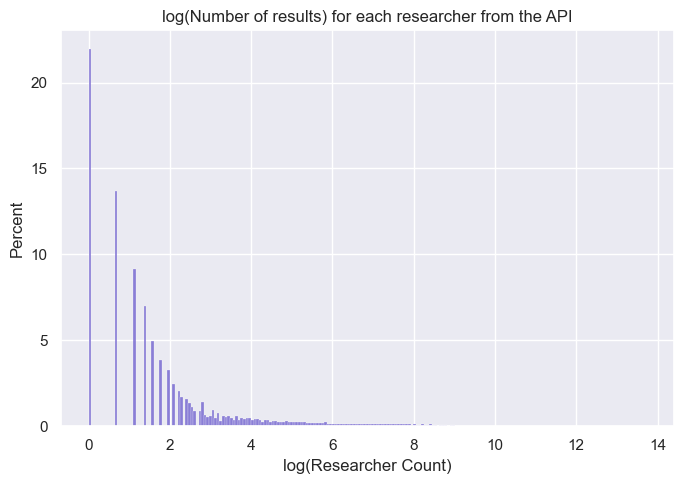

In [10]:
sns.histplot(data = researchers, x = 'log_AuthorCount', stat = 'percent', color = 'slateblue')
plt.xlabel('log(Researcher Count)')
plt.title('log(Number of results) for each researcher from the API')
plt.tight_layout()
plt.savefig("Figures/authorCount.png", bbox_inches='tight')
plt.show()

### Field

In [11]:
field_API = (uniqueResearchers.groupby('API_Field').count()/(len(uniqueResearchers))*100).sort_values(by ='SearchName', ascending = False).reset_index()
fields_external = (uniqueResearchers.groupby('ExternalField').count()/(len(uniqueResearchers))*100).sort_values(by ='SearchName', ascending = False).reset_index()
fields_model = (uniqueResearchers.groupby('ModelField').count()/(len(uniqueResearchers))*100).sort_values(by ='SearchName', ascending = False).reset_index()

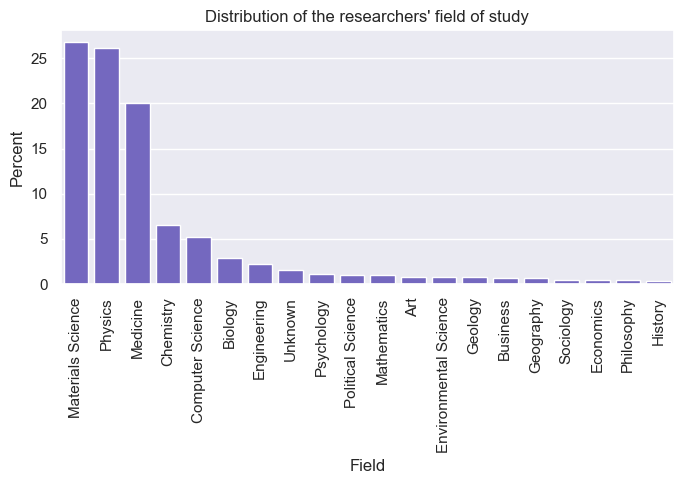

In [12]:
sns.barplot(data = field_API, x = 'API_Field', y = 'SearchName', color = 'slateblue')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Percent')
plt.title("Distribution of the researchers' field of study")
plt.tight_layout()
plt.savefig("Figures/fieldPlot_API.png", bbox_inches='tight')
plt.show()

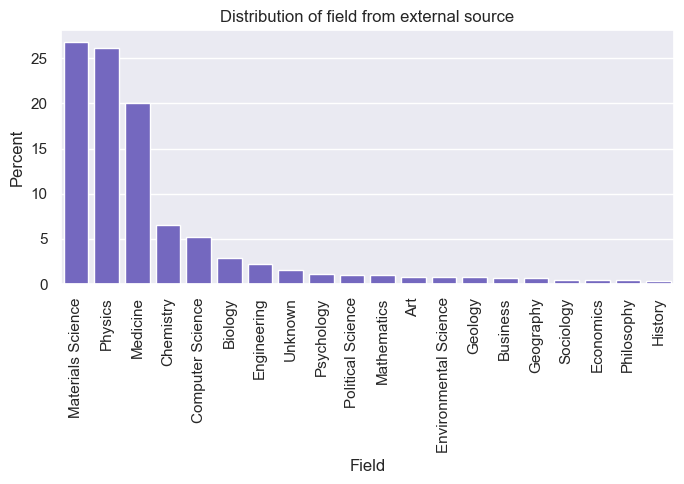

In [13]:
sns.barplot(data = fields_external, x = 'ExternalField', y = 'SearchName', color = 'slateblue')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Percent')
plt.title("Distribution of field from external source")
plt.tight_layout()
plt.savefig("Figures/fieldPlot_external.png", bbox_inches='tight')
plt.show()

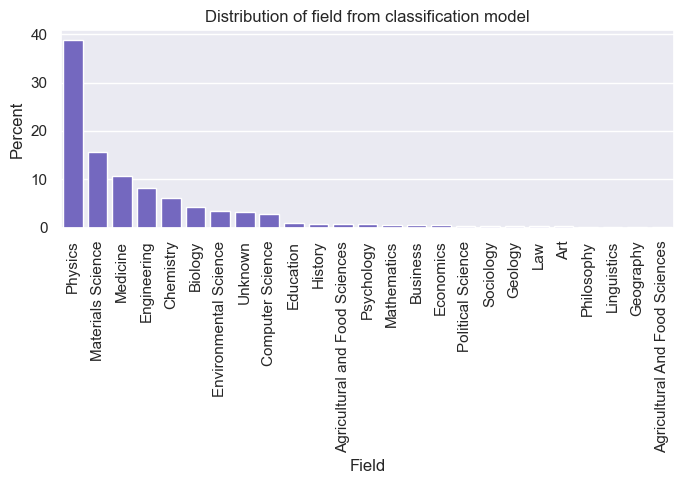

In [14]:
sns.barplot(data = fields_model, x = 'ModelField', y = 'SearchName', color = 'slateblue')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Percent')
plt.title("Distribution of field from classification model")
plt.tight_layout()
plt.savefig("Figures/fieldPlot_model.png", bbox_inches='tight')
plt.show()

In [15]:
#create column with 1 if ModelField and ExternalField is the same
uniqueResearchers['SameField'] = np.where(uniqueResearchers['ExternalField'] == uniqueResearchers['ModelField'], 1, 0)

In [16]:
print("Share of researchers with same field from model and external sources:", len(uniqueResearchers[uniqueResearchers.SameField == 1])/len(uniqueResearchers))
print("Share of researchers with different field from model and external sources:", len(uniqueResearchers[uniqueResearchers.SameField == 0])/len(uniqueResearchers))

Share of researchers with same field from model and external sources: 0.5553983969825554
Share of researchers with different field from model and external sources: 0.4446016030174446


### Researchers within medicine

In [17]:
medicineResearchers_API = uniqueResearchers[uniqueResearchers.API_Field == 'Medicine'].reset_index()
medicineResearchers_external = uniqueResearchers[uniqueResearchers.ExternalField == 'Medicine'].reset_index()
medicineResearchers_model = uniqueResearchers[uniqueResearchers.ModelField == 'Medicine'].reset_index()

In [18]:
medicineResearchers_fieldCount_external = medicineResearchers_external.groupby('ExternalFieldCount').count().reset_index()
medicineResearchers_fieldCount_model = medicineResearchers_model.groupby('ModelFieldCount').count().reset_index()

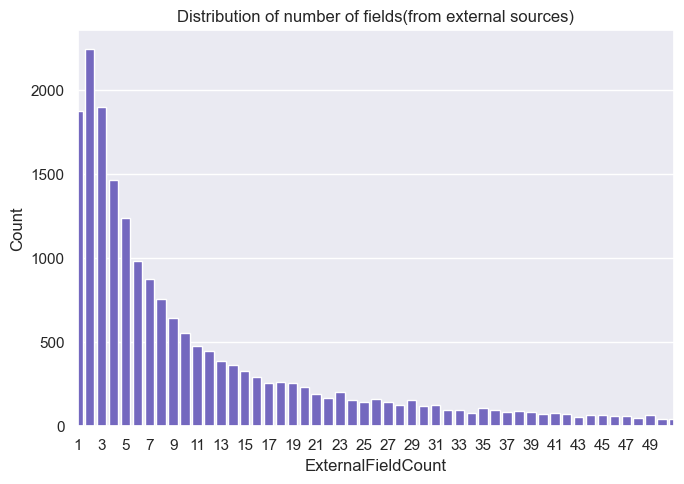

In [19]:
sns.barplot(data = medicineResearchers_fieldCount_external, x = 'ExternalFieldCount', y = 'SearchName', color = 'slateblue')
plt.xlim(0,50)
plt.xticks(np.arange(0,50, 2)) 
plt.ylabel('Count')
plt.title("Distribution of number of fields(from external sources)")
plt.tight_layout()
plt.savefig("Figures/fieldCount_medicine_external.png", bbox_inches='tight')
plt.show()

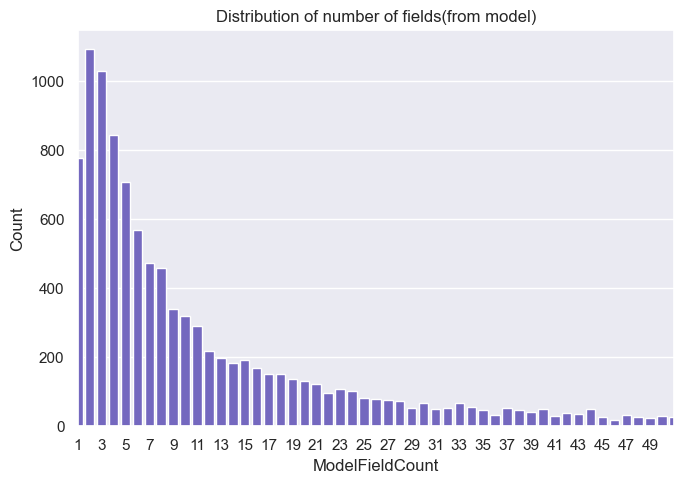

In [20]:
sns.barplot(data = medicineResearchers_fieldCount_model, x = 'ModelFieldCount', y = 'SearchName', color = 'slateblue')
plt.xlim(0,50)
plt.xticks(np.arange(0,50, 2)) 
plt.ylabel('Count')
plt.title("Distribution of number of fields(from model)")
plt.tight_layout()
plt.savefig("Figures/fieldCount_Model.png", bbox_inches='tight')
plt.show()

## Plots

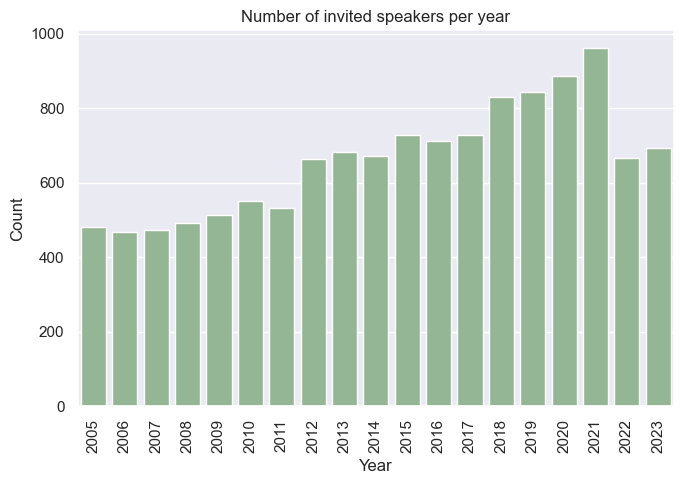

In [21]:
sns.countplot(x = 'Year', data = invited , color = 'darkseagreen')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Number of invited speakers per year')
plt.tight_layout()
plt.savefig("Figures/invitedSpeakers.png", bbox_inches='tight')
plt.show()

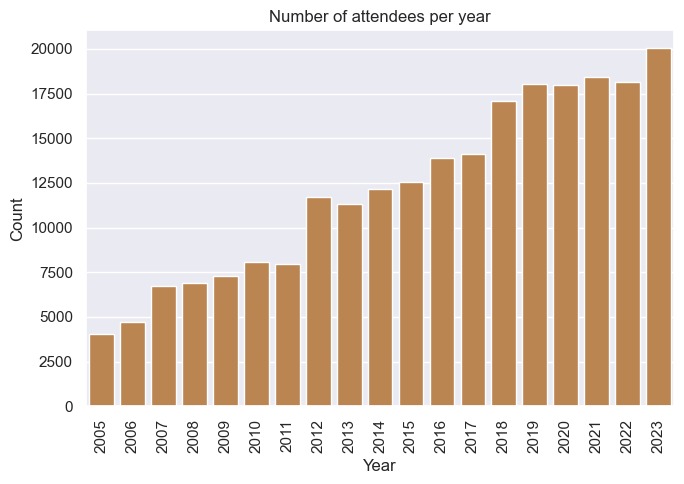

In [22]:
sns.countplot(x = 'Year', data = attendees , color = 'peru')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Number of attendees per year')
plt.tight_layout()
plt.savefig("Figures/participants.png", bbox_inches='tight')
plt.show()

### Researcher not found

In [23]:
errorResearchersGender_inv = errorResearchers_gender[errorResearchers_gender.SessionType == 'invited']
errorResearchersGender_att = errorResearchers_gender[errorResearchers_gender.SessionType == 'attendee']

In [24]:
#percent errorResearchers of total invited speakers and attendees
errorInvited_percent = ((errorResearchersGender_inv.groupby('Year').count()['SearchName']/(errorResearchersGender_inv.groupby('Year').count()['SearchName'] + invited.groupby('Year').count()['SearchName']))*100).reset_index()
errorAttendees_percent = ((errorResearchersGender_att.groupby('Year').count()['SearchName']/(errorResearchersGender_att.groupby('Year').count()['SearchName'] + attendees.groupby('Year').count()['SearchName']))*100).reset_index()

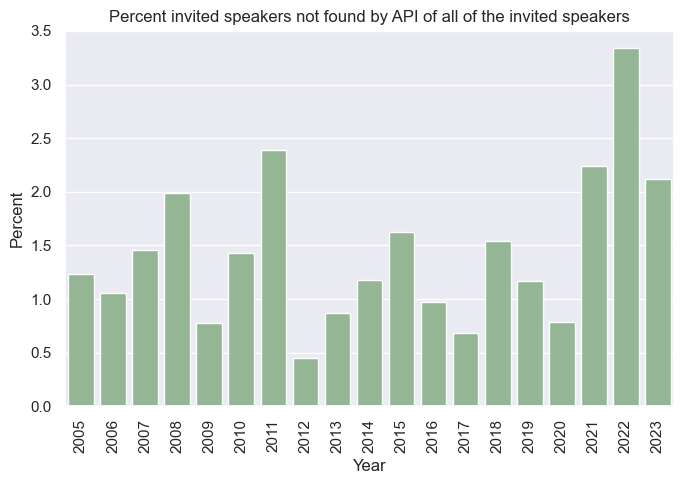

In [25]:
sns.barplot(data = errorInvited_percent, x = 'Year', y = 'SearchName', color = 'darkseagreen')
plt.xticks(rotation=90)
plt.ylabel('Percent')
plt.title('Percent invited speakers not found by API of all of the invited speakers')
plt.tight_layout()
plt.savefig("Figures/invitedSpeakers_errorResearchers.png", bbox_inches='tight')
plt.show()

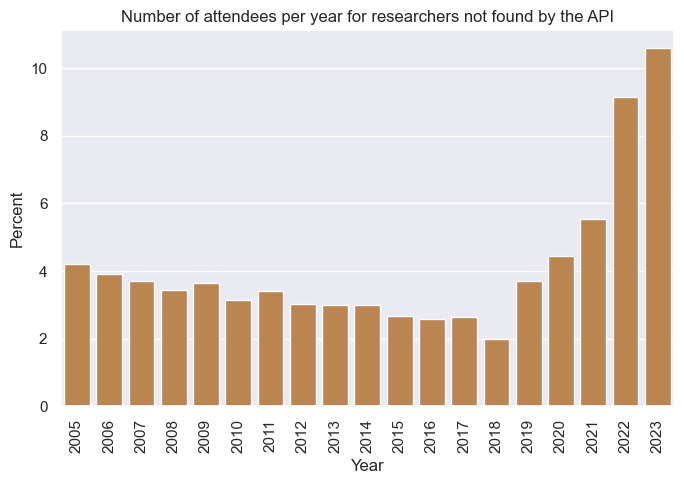

In [26]:
sns.barplot(x = 'Year', data = errorAttendees_percent, y = 'SearchName', color = 'peru')
plt.xticks(rotation=90)
plt.ylabel('Percent')
plt.title('Number of attendees per year for researchers not found by the API')
plt.tight_layout()
plt.savefig("Figures/participants_errorResearchers.png", bbox_inches='tight')
plt.show()

In [27]:
#calculate gender ratio
errorResearcher_genderRatio_inv = pd.crosstab(index=errorResearchersGender_inv.Year,
                             columns=errorResearchersGender_inv.Gender,
                             normalize="index").rename(columns = {'Female': 'Female invited', 'Male': 'Male invited', 'Unknown': 'Unknown invited'})

errorResearcher_genderRatio_att = pd.crosstab(index=errorResearchersGender_att.Year,
                             columns=errorResearchersGender_att.Gender,
                             normalize="index").rename(columns = {'Female': 'Female attendees', 'Male': 'Male attendees', 'Unknown': 'Unknown attendees'})

In [28]:
#change order of columns
columns_inv = errorResearcher_genderRatio_inv.columns.tolist()
columns_att = errorResearcher_genderRatio_att.columns.tolist()

cols_inv = columns_inv[-1:] +  columns_inv[:2]
cols_att = columns_att[-1:] +  columns_att[:2]

errorResearcher_genderRatio_inv = errorResearcher_genderRatio_inv[cols_inv]
errorResearcher_genderRatio_att = errorResearcher_genderRatio_att[cols_att]

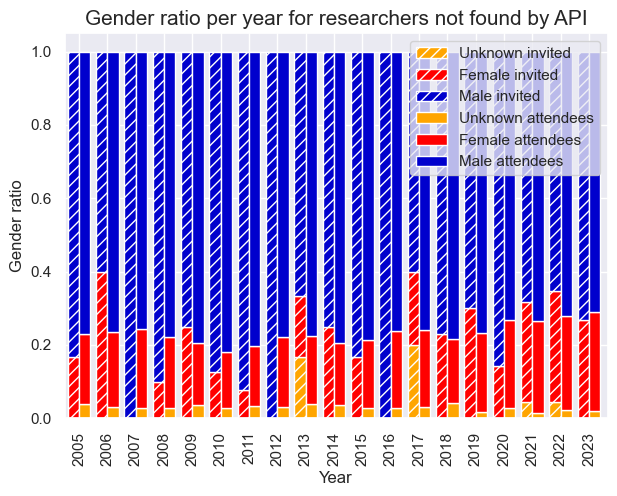

In [29]:
fig, ax = plt.subplots()
errorResearcher_genderRatio_inv.plot(kind='bar', stacked=True, width = 0.4, position = 1, ax = ax, color = ['orange', 'red', 'mediumblue'], hatch = '///')
errorResearcher_genderRatio_att.plot(kind='bar', stacked=True, width = 0.4, position=0, ax = ax, color = ['orange', 'red', 'mediumblue'])
ax.set_xlim(left=-0.5)
plt.legend(loc="upper right", ncol = 1)
plt.title("Gender ratio per year for researchers not found by API", fontsize = 15)
plt.xlabel("Year")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio_notFound.png", bbox_inches='tight')
plt.show()

### Sponsoring Units

In [30]:
#invited_divisions = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'invited']
#attendees_divisions = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'attendee']

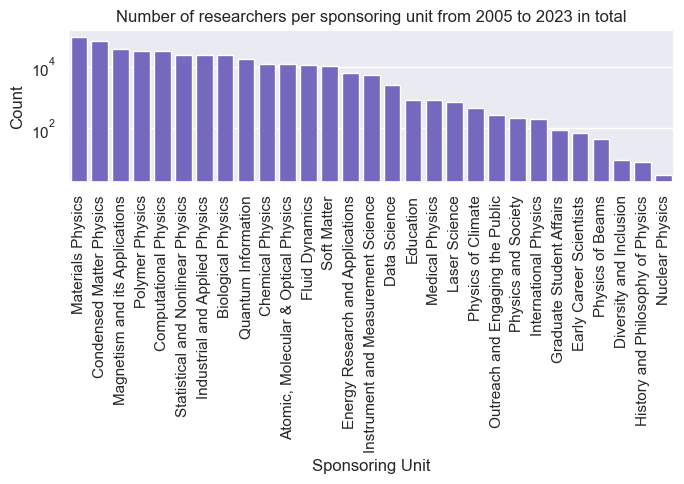

In [31]:
sns.countplot(data = sponsUnitResearchers, x = 'AssignedSponsoringUnit', order = sponsUnitResearchers.AssignedSponsoringUnit.value_counts().index, color = 'slateblue')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Sponsoring Unit')
plt.title('Number of researchers per sponsoring unit from 2005 to 2023 in total')
plt.tight_layout()
plt.savefig("Figures/sponsoringUnits_count.png", bbox_inches='tight')
plt.show()

In [44]:
order = sponsUnitResearchers.AssignedSponsoringUnit.value_counts().index.values
order

array(['Materials Physics', 'Condensed Matter Physics',
       'Magnetism and its Applications', 'Polymer Physics',
       'Computational Physics', 'Statistical and Nonlinear Physics',
       'Industrial and Applied Physics', 'Biological Physics',
       'Quantum Information', 'Chemical Physics',
       'Atomic, Molecular & Optical Physics', 'Fluid Dynamics',
       'Soft Matter', 'Energy Research and Applications',
       'Instrument and Measurement Science', 'Data Science', 'Education',
       'Medical Physics', 'Laser Science', 'Physics of Climate',
       'Outreach and Engaging the Public', 'Physics and Society',
       'International Physics', 'Graduate Student Affairs',
       'Early Career Scientists', 'Physics of Beams',
       'Diversity and Inclusion', 'History and Philosophy of Physics',
       'Nuclear Physics'], dtype=object)

In [47]:
#sponsUnitResearchers['Item'] = pd.Categorical(df['Item'], ['Up','Down','Left','Right'])
sponsUnitResearchers['AssignedSponsoringUnit'] = pd.Categorical(sponsUnitResearchers.AssignedSponsoringUnit, order)

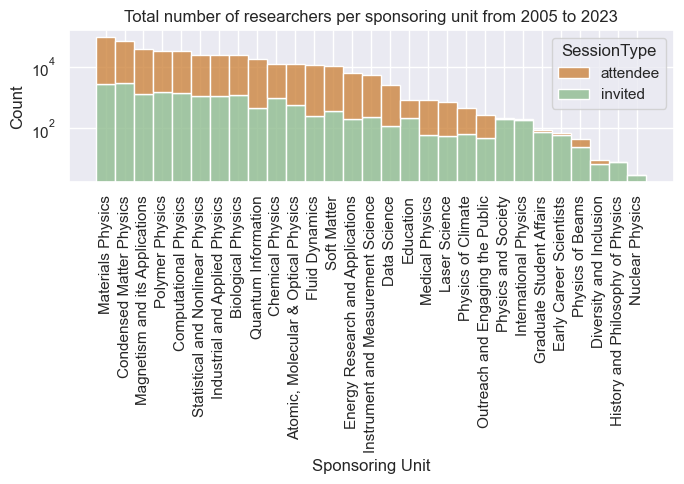

In [50]:
sns.histplot(sponsUnitResearchers, x = 'AssignedSponsoringUnit', hue='SessionType', multiple='stack', palette = ['peru', 'darkseagreen'], alpha = 0.8)
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Sponsoring Unit')
plt.title('Total number of researchers per sponsoring unit from 2005 to 2023')
plt.tight_layout()
plt.savefig("Figures/sponsoringUnits_count_wSessType.png", bbox_inches='tight')
plt.show()

In [ ]:
#find a way to order the data
#maybe it should be converted to barplot, where we count number of occurences, but still keep hue
sns.histplot(sponsUnitResearchers, x='AssignedSponsoringUnit', hue='SessionType', multiple='stack', weights= sponsUnitResearchers.AssignedSponsoringUnit, palette = ['peru', 'darkseagreen'], alpha = 0.8)



In [ ]:
#this should be ratio instead (the ones below)

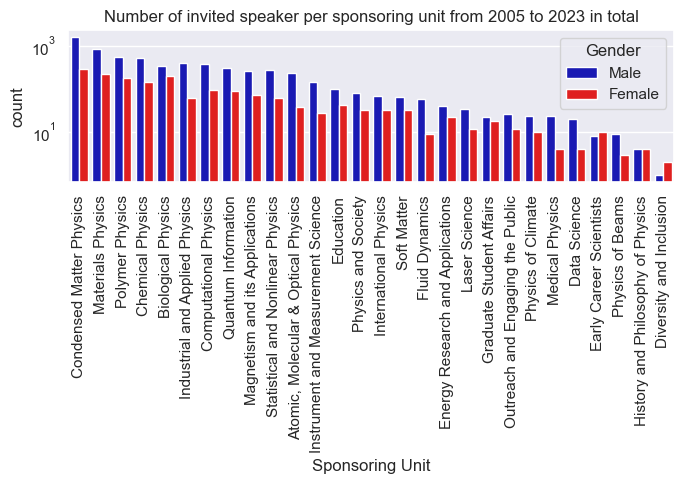

In [83]:
sns.countplot(data = invited_divisions, x = 'AssignedSponsoringUnit', order = invited_divisions.AssignedSponsoringUnit.value_counts().index, hue = 'Gender', palette=["mediumblue", "red"])
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Sponsoring Unit')
plt.title('Number of invited speaker per sponsoring unit from 2005 to 2023 in total')
plt.tight_layout()
plt.savefig("Figures/invited_divisions.png", bbox_inches='tight')
plt.show()

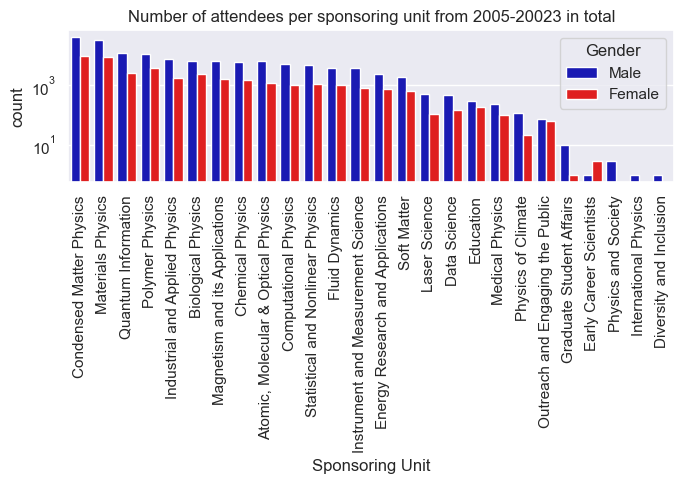

In [86]:
sns.countplot(data = attendees_divisions, x = 'AssignedSponsoringUnit', order = attendees_divisions.AssignedSponsoringUnit.value_counts().index, hue = 'Gender', palette=["mediumblue", "red"])
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Sponsoring Unit')
plt.title('Number of attendees per sponsoring unit from 2005-20023 in total')
plt.tight_layout()
plt.savefig("Figures/participants_sponsoringUnit.png", bbox_inches='tight')
plt.show()

### Gender

In [126]:
#calculate gender ratio
genderRatio_invited = pd.crosstab(index=invited.Year,
                             columns=invited.Gender,
                             normalize="index").rename(columns = {'Female': 'Female invited', 'Male': 'Male invited'})

genderRatio_attendees = pd.crosstab(index=attendees.Year,
                             columns=attendees.Gender,
                             normalize="index").rename(columns = {'Female': 'Female attendees', 'Male': 'Male attendees'})

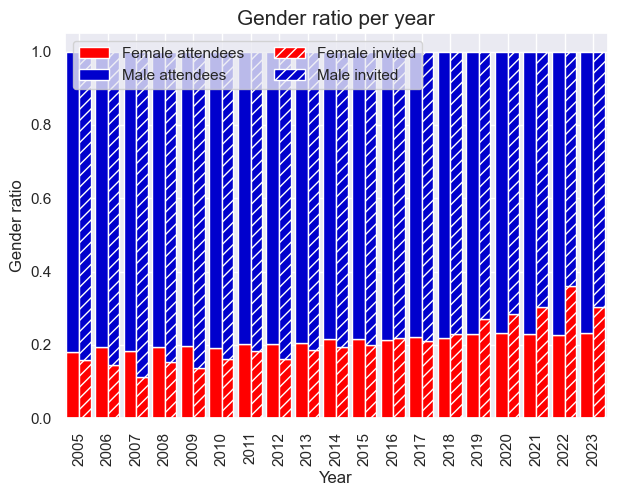

In [225]:
fig, ax = plt.subplots()
genderRatio_attendees.plot(kind='bar', stacked=True, width = 0.45, position = 1, ax = ax, color = ['red', 'mediumblue'])
genderRatio_invited.plot(kind='bar', stacked=True, width = 0.4, position=0, ax = ax, color = ['red', "mediumblue"], hatch = '///')
#ax.set_xlim(right=len(genderRatio_invited)-0.5)
ax.set_xlim(left=-0.5)
ax.set_xlim(right=len(genderRatio_invited)-0.5)
#ax.set_edgecolor(color = 'black')
plt.legend(loc="upper left", ncol = 2)
plt.title("Gender ratio per year", fontsize = 15)
plt.xlabel("Year")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio.png", bbox_inches='tight')
plt.show()

In [232]:
divGenderRatio_invited = pd.crosstab(index=invited_divisions.Division,
                             columns=invited_divisions.Gender,
                             normalize="index").rename(columns = {'Female': 'Female invited', 'Male': 'Male invited'})

divGenderRatio_attendees = pd.crosstab(index=attendees_divisions.Division,
                             columns=attendees_divisions.Gender,
                             normalize="index").rename(columns = {'Female': 'Female attendees', 'Male': 'Male attendees'})

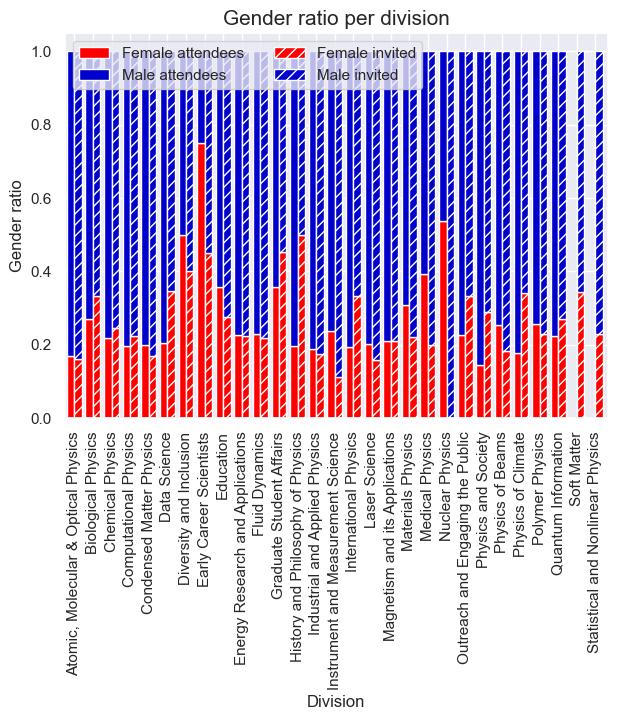

In [233]:
fig, ax = plt.subplots()
divGenderRatio_attendees.plot(kind='bar', stacked=True, width = 0.4, position = 1, ax = ax, color = ['red', 'mediumblue'])
divGenderRatio_invited.plot(kind='bar', stacked=True, width = 0.4, position=0, ax = ax, color = ['red', "mediumblue"], hatch = '///')
ax.set_xlim(left=-0.5)
plt.legend(loc="upper left", ncol = 2)
plt.title("Gender ratio per division", fontsize = 15)
plt.xlabel("Division")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio_Divisions.png", bbox_inches='tight')
plt.show()

In [130]:
invitedSpeakers_genderCount = invited.groupby(['Year', 'Gender']).count().reset_index()
participants_genderCount = attendees.groupby(['Year', 'Gender']).count().reset_index()

In [131]:
#get lineplot to show int as in data and not 
years = invitedSpeakers_genderCount.Year.unique().tolist()

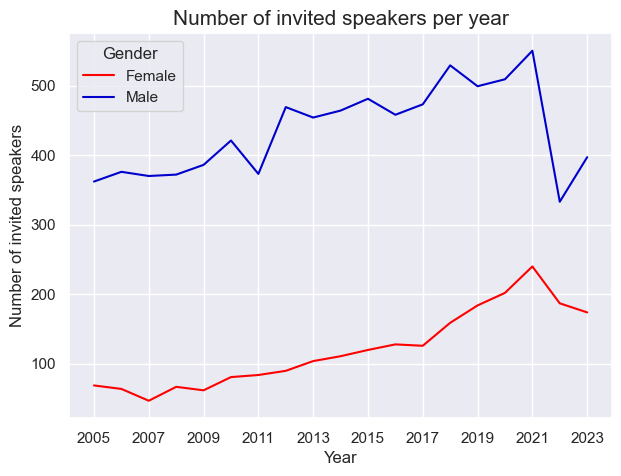

In [132]:
sns.lineplot(data = invitedSpeakers_genderCount, x = 'Year', y = 'Name', hue = 'Gender',  palette=['red', 'mediumblue'])
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of invited speakers", fontsize=12)
plt.title("Number of invited speakers per year", fontsize = 15)
plt.savefig("Figures/nInvitedSpeakers.png", bbox_inches='tight')
plt.show()

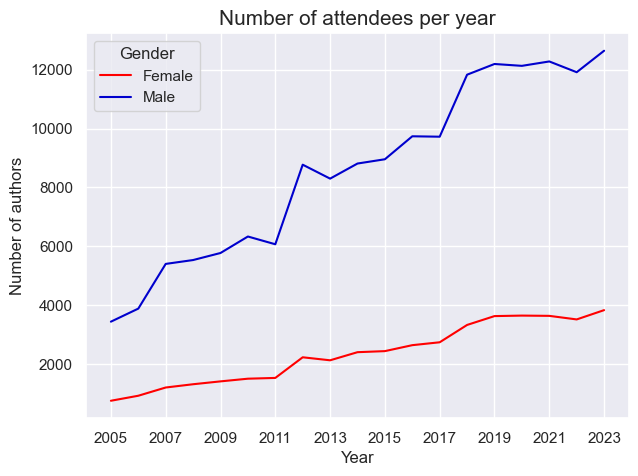

In [133]:
sns.lineplot(data = participants_genderCount, x = 'Year', y = 'Name', hue = 'Gender',  palette=["red", "mediumblue"])
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of authors", fontsize=12)
plt.title("Number of attendees per year", fontsize = 15)
plt.savefig("Figures/nParticipants.png", bbox_inches='tight')
plt.show()

In [134]:
#calculate percentage increase
invitedSpeakers_genderCount_F = invitedSpeakers_genderCount[invitedSpeakers_genderCount.Gender == 'Female']
invitedSpeakers_genderCount_M = invitedSpeakers_genderCount[invitedSpeakers_genderCount.Gender == 'Male']
participants_genderCount_F = participants_genderCount[participants_genderCount.Gender == 'Female']
participants_genderCount_M = participants_genderCount[participants_genderCount.Gender == 'Male']

#calculate and add the increase
invitedSpeakers_genderCount_F['Increase'] = invitedSpeakers_genderCount_F.ID.pct_change().fillna(0) * 100
invitedSpeakers_genderCount_M['Increase'] = invitedSpeakers_genderCount_M.ID.pct_change().fillna(0) * 100
participants_genderCount_F['Increase'] = participants_genderCount_F.ID.pct_change().fillna(0) * 100
participants_genderCount_M['Increase'] = participants_genderCount_M.ID.pct_change().fillna(0) * 100

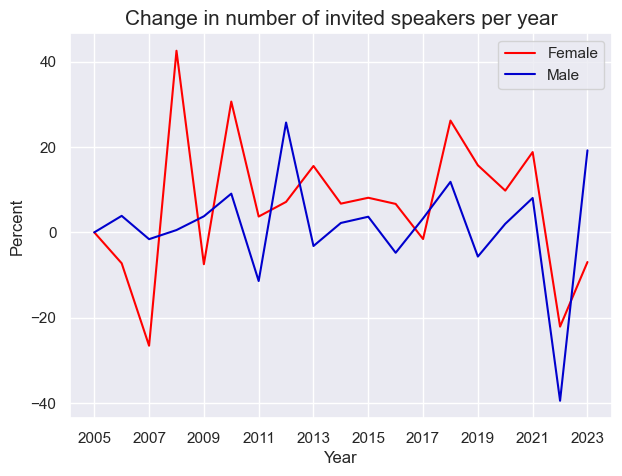

In [135]:
sns.lineplot(data = invitedSpeakers_genderCount_F, x = 'Year', y = 'Increase', color = 'red', label = 'Female')
sns.lineplot(data = invitedSpeakers_genderCount_M, x = 'Year', y = 'Increase', color = 'mediumblue', label = 'Male')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Percent", fontsize=12)
plt.title("Change in number of invited speakers per year", fontsize = 15)
plt.savefig("Figures/invited_change.png", bbox_inches='tight')
plt.show()

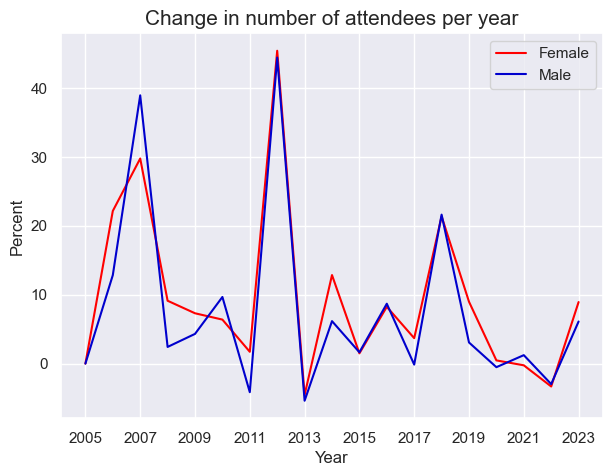

In [136]:
sns.lineplot(data = participants_genderCount_F, x = 'Year', y = 'Increase', color = 'red', label = 'Female')
sns.lineplot(data = participants_genderCount_M, x = 'Year', y = 'Increase', color = 'mediumblue', label = 'Male')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Percent", fontsize=12)
plt.title("Change in number of attendees per year", fontsize = 15)
plt.savefig("Figures/attendees_change.png", bbox_inches='tight')
plt.show()

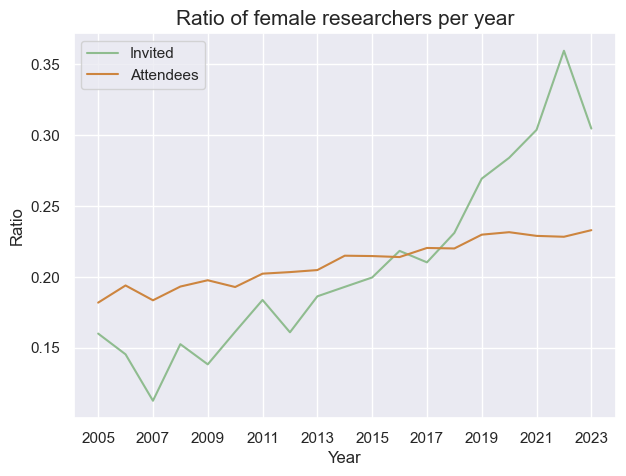

In [137]:
sns.lineplot(data = genderRatio_invited.reset_index(), x = 'Year', y = 'Female invited', color = 'darkseagreen', label = 'Invited')
sns.lineplot(data = genderRatio_attendees.reset_index(), x = 'Year', y = 'Female attendees', color = 'peru', label = 'Attendees')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.title("Ratio of female researchers per year", fontsize = 15)
plt.savefig("Figures/FemaleRatio.png", bbox_inches='tight')
plt.show()

### Publications

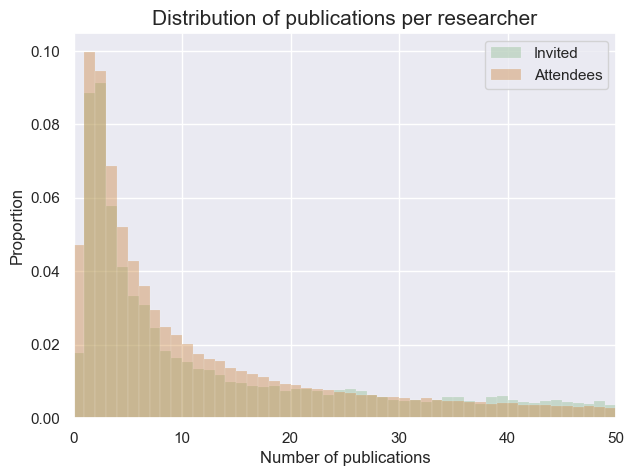

In [160]:
sns.histplot(data = invited, x = 'CumulativePaperCount', stat = 'proportion', color = 'darkseagreen', label = 'Invited', alpha = 0.4, binwidth = 1)
sns.histplot(data = attendees, x = 'CumulativePaperCount', stat = 'proportion', color = 'peru', label = 'Attendees', alpha = 0.4, binwidth = 1)
plt.legend()
plt.xlim(0, 50)
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per researcher", fontsize = 15)
plt.savefig("Figures/publications_dist_all.png", bbox_inches='tight')
plt.show()

In [143]:
maleInv = invited[invited.Gender == 'Male']
femaleInv = invited[invited.Gender == 'Female']
maleAtt = attendees[attendees.Gender == 'Male']
femaleAtt = attendees[attendees.Gender == 'Female']

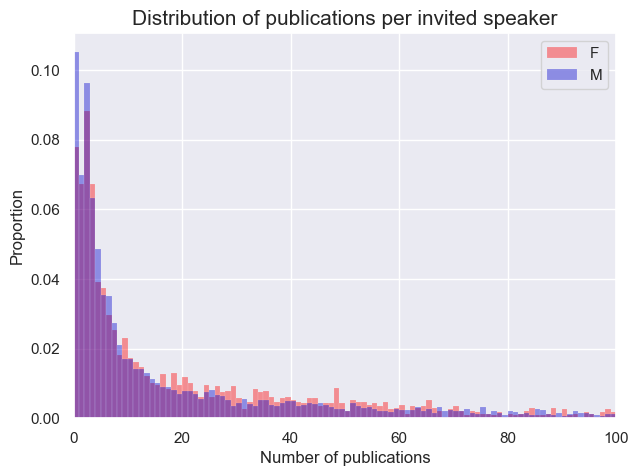

In [145]:
#same plot as the one above
sns.histplot(data = femaleInv, x = 'CumulativePaperCount', stat = 'proportion', color = 'red', label = 'F', binwidth = 1, alpha = 0.4)
sns.histplot(data = maleInv, x = 'CumulativePaperCount', stat = 'proportion', color = 'mediumblue', label = 'M', binwidth = 1, alpha = 0.4)
plt.legend()
plt.xlim(0, 100)
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per invited speaker", fontsize = 15)
plt.savefig("Figures/publications_dist_invited.png", bbox_inches='tight')
plt.show()

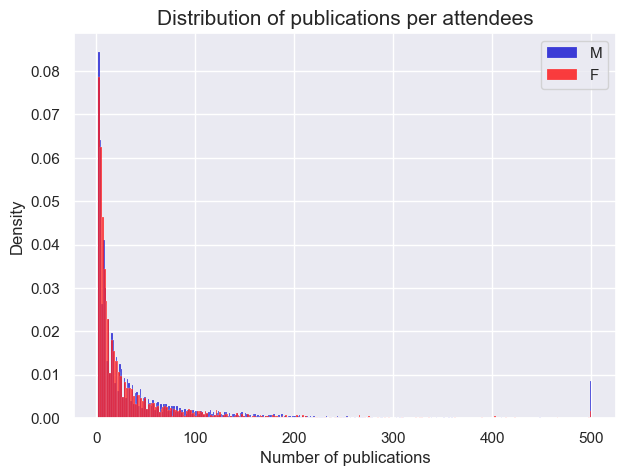

In [146]:
sns.histplot(data = maleAtt, x = 'MaxPaperCount', stat = 'density', color = 'mediumblue', label = 'M')
sns.histplot(data = femaleAtt, x = 'MaxPaperCount', stat = 'density', color = 'red', label = 'F')
plt.legend()
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per attendees", fontsize = 15)
plt.savefig("Figures/publications_dist_attendees.png", bbox_inches='tight')
plt.show()

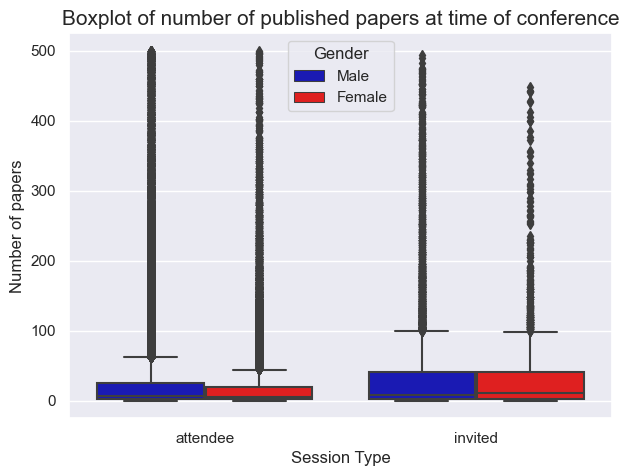

In [147]:
#boxplot of cumulative paper count
sns.boxplot(data=researchers, x="SessionType", y="CumulativePaperCount", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Number of papers", fontsize=12)
plt.title("Boxplot of number of published papers at time of conference", fontsize = 15)
plt.savefig("Figures/maxPaperCount_boxplot", bbox_inches='tight')
plt.show()

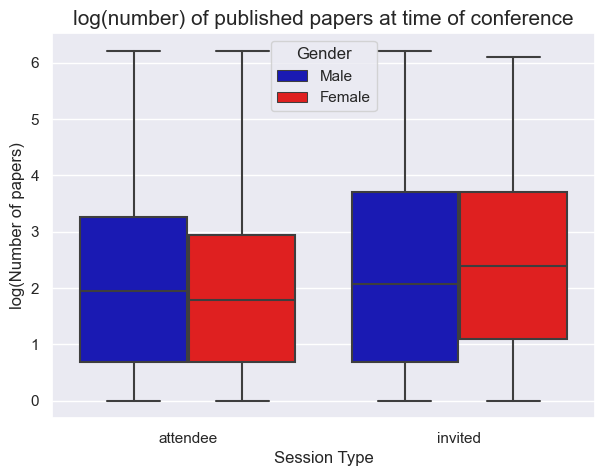

In [148]:
#boxplot of maxPaperCount
sns.boxplot(data=researchers, x="SessionType", y="log_CumulativePaperCount", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("log(Number of papers)", fontsize=12)
plt.title("log(number) of published papers at time of conference", fontsize = 15)
plt.savefig("Figures/maxPaperCount_boxplot", bbox_inches='tight')
plt.show()

#not #not containing researchers not publishing anything

In [149]:
bins = np.arange(0, 35, 5).tolist()
bins.append(float("inf"))
labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '> 30']

In [150]:
#create seniority categories
researchers['Seniority_cat'] = pd.cut(researchers['Seniority'], bins = bins, labels = labels)

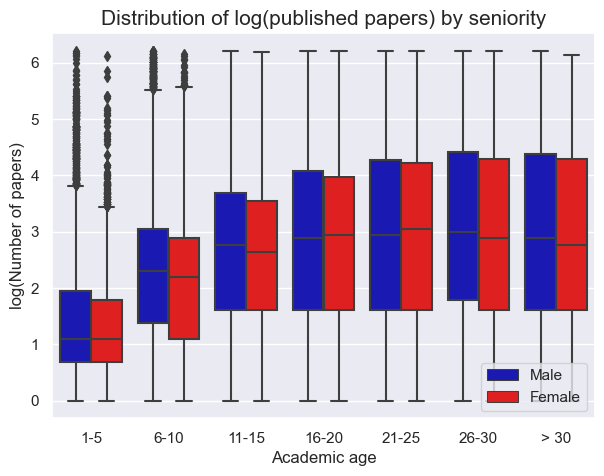

In [151]:
sns.boxplot(data=researchers , x="Seniority_cat", y='log_CumulativePaperCount', hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Academic age", fontsize=12)
plt.ylabel("log(Number of papers)", fontsize=12)
plt.title("Distribution of log(published papers) by seniority", fontsize = 15)
plt.legend(loc="lower right")
plt.savefig("Figures/paperCount_Seniority_boxplot", bbox_inches='tight')
plt.show()

### Seniority

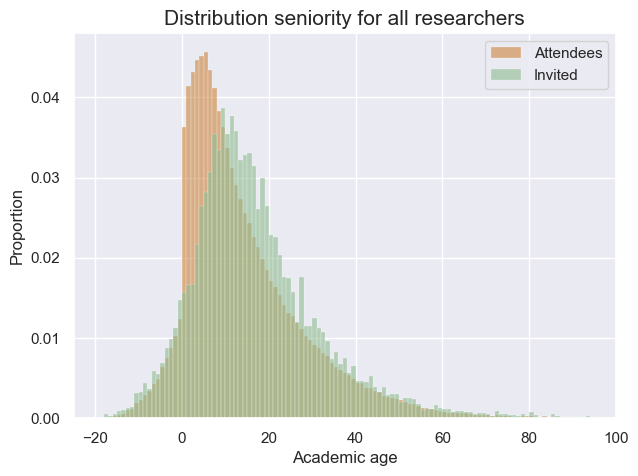

In [152]:
#distribution of seniority
sns.histplot(data = attendees, x = 'Seniority', stat = 'proportion', color = 'peru', label = 'Attendees', alpha = 0.6, binwidth = 1)
sns.histplot(data = invited, x = 'Seniority', stat = 'proportion', color = 'darkseagreen', label = 'Invited', alpha = 0.6, binwidth = 1)
plt.xlim(-25, 100)
plt.legend()
plt.xlabel("Academic age", fontsize=12)
plt.title("Distribution seniority for all researchers", fontsize = 15)
plt.savefig("Figures/seniorityDist_all.png", bbox_inches='tight')
plt.show()

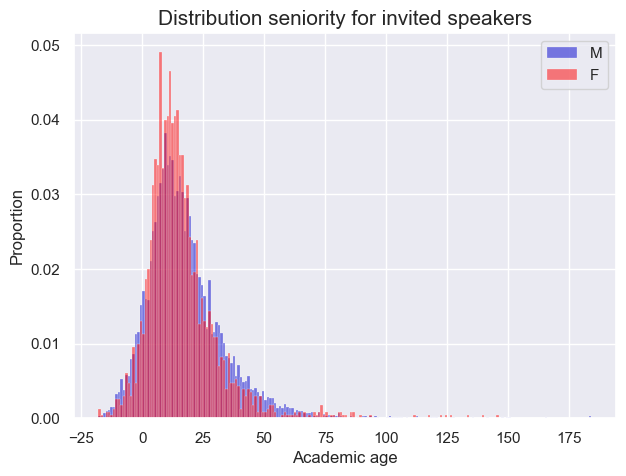

In [153]:
sns.histplot(data = maleInv , x = 'Seniority', stat = 'proportion', color = 'mediumblue', label = 'M', alpha = 0.5, binwidth = 1)
sns.histplot(data = femaleInv, x = 'Seniority', stat = 'proportion', color = 'red', label = 'F', alpha = 0.5, binwidth = 1)
plt.legend()
plt.xlabel("Academic age", fontsize=12)
plt.title("Distribution seniority for invited speakers", fontsize = 15)
plt.savefig("Figures/seniorityDist_Invited.png", bbox_inches='tight')
plt.show()

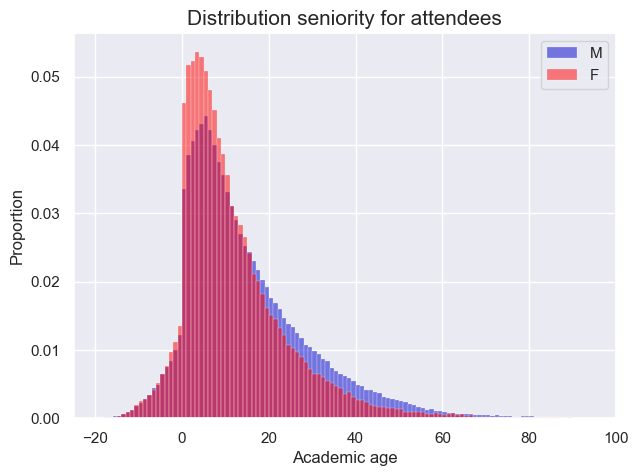

In [154]:
sns.histplot(data = maleAtt , x = 'Seniority', stat = 'proportion', color = 'mediumblue', label = 'M', alpha = 0.5, binwidth = 1)
sns.histplot(data = femaleAtt, x = 'Seniority', stat = 'proportion', color = 'red', label = 'F', alpha = 0.5, binwidth = 1)
plt.legend()
plt.xlim(-25, 100)
plt.xlabel("Academic age", fontsize=12)
plt.title("Distribution seniority for attendees", fontsize = 15)
plt.savefig("Figures/seniorityDist_Attendees.png", bbox_inches='tight')
plt.show()

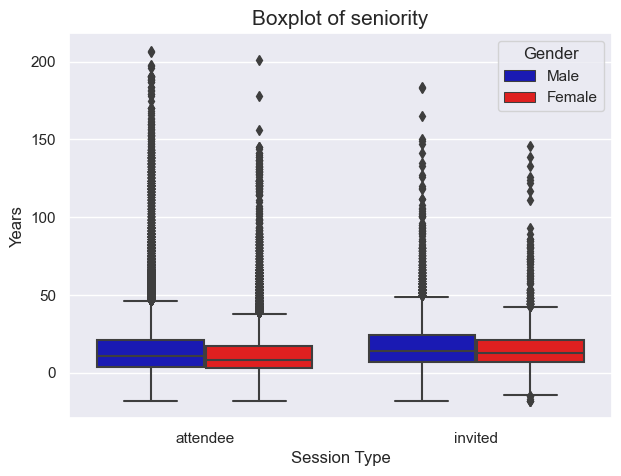

In [155]:
#boxplot of seniority
sns.boxplot(data=researchers , x="SessionType", y="Seniority", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Years", fontsize=12)
plt.title("Boxplot of seniority", fontsize = 15)
plt.savefig("Figures/seniority_boxplot", bbox_inches='tight')
plt.show()

#### Negative seniority

In [156]:
negativeSeniority_inv = invited[invited.Seniority < 0]
negativeSeniority_att = attendees[attendees.Seniority < 0]

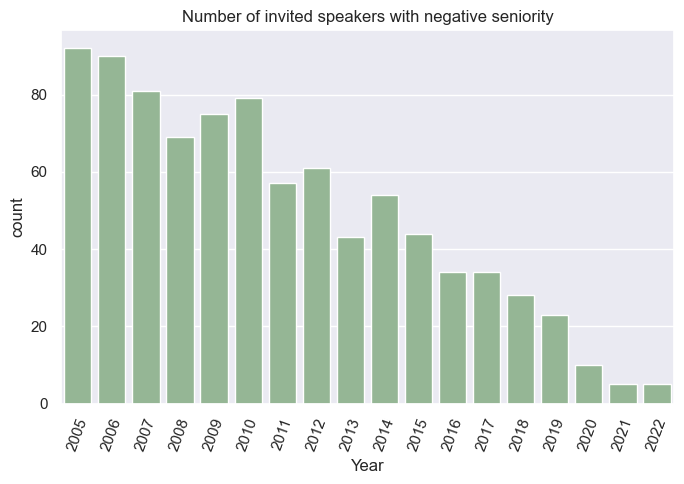

In [157]:
sns.countplot(data = negativeSeniority_inv, x = "Year", color = 'darkseagreen')
plt.xticks(rotation=70)
plt.title('Number of invited speakers with negative seniority')
plt.tight_layout()
plt.savefig("Figures/negativeSeniority_invited.png", bbox_inches='tight')
plt.show()

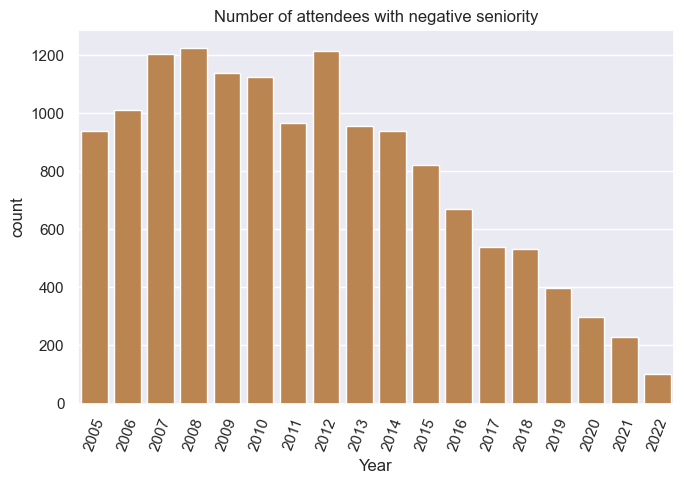

In [158]:
sns.countplot(data = negativeSeniority_att, x = "Year", color = 'peru')
plt.xticks(rotation=70)
plt.title('Number of attendees with negative seniority')
plt.tight_layout()
plt.savefig("Figures/negativeSeniority_attendees.png", bbox_inches='tight')
plt.show()

In [ ]:
#it seems to be decreasing problem with negative seniority. 

### Productivity

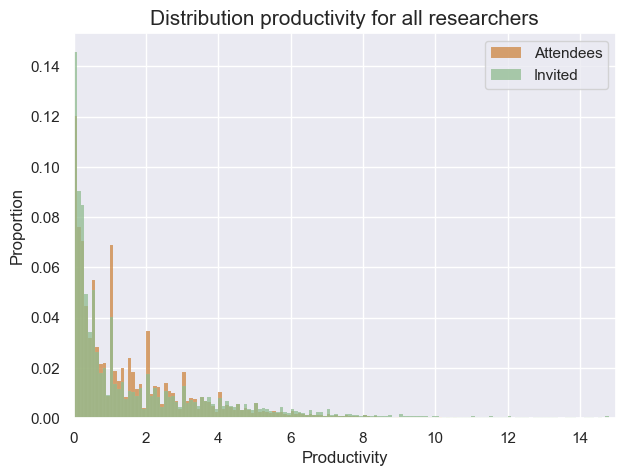

In [159]:
sns.histplot(data = attendees, x = 'Productivity', stat = 'proportion', color = 'peru', label = 'Attendees', binwidth = 0.1)
sns.histplot(data = invited, x = 'Productivity', stat = 'proportion', color = 'darkseagreen', label = 'Invited', binwidth = 0.1)
plt.legend()
plt.xlim(0, 15)
plt.title("Distribution productivity for all researchers", fontsize = 15)
plt.savefig("Figures/productivityDist_all.png", bbox_inches='tight')
plt.show()

#invited: darkseagreen
#attendees: peru

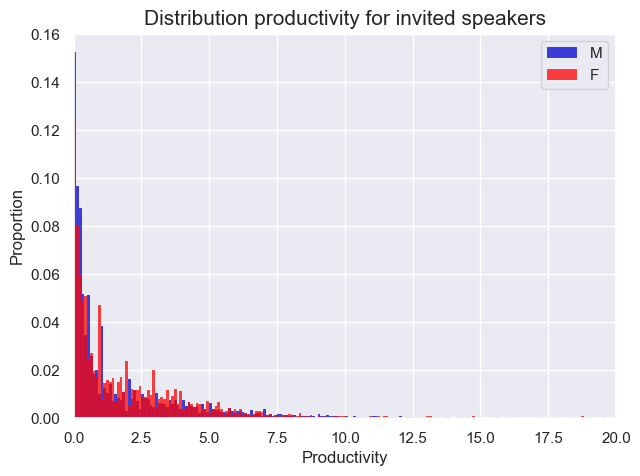

In [160]:
sns.histplot(data = maleInv , x = 'Productivity', stat = 'proportion', color = 'mediumblue', label = 'M', binwidth = 0.1)
sns.histplot(data = femaleInv, x = 'Productivity', stat = 'proportion', color = 'red', label = 'F', binwidth = 0.1)
plt.legend()
plt.xlim(0,20)
plt.title("Distribution productivity for invited speakers", fontsize = 15)
plt.savefig("Figures/productivityDist_Invited.png", bbox_inches='tight')
plt.show()

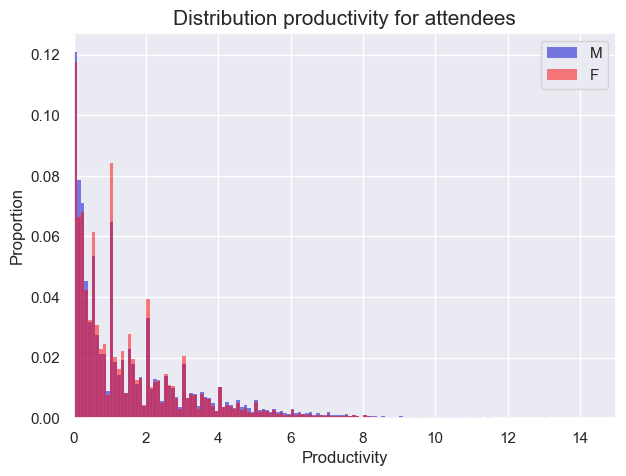

In [161]:
sns.histplot(data = maleAtt , x = 'Productivity', stat = 'proportion', color = 'mediumblue', label = 'M', alpha = 0.5, binwidth = 0.1)
sns.histplot(data = femaleAtt, x = 'Productivity', stat = 'proportion', color = 'red', label = 'F', alpha = 0.5, binwidth = 0.1)
plt.legend()
plt.xlim(0,15)
plt.title("Distribution productivity for attendees", fontsize = 15)
plt.savefig("Figures/productivityDist_Attendees.png", bbox_inches='tight')
plt.show()

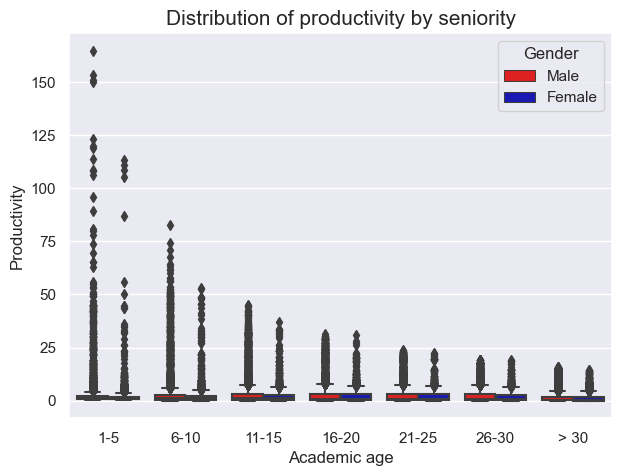

In [162]:
sns.boxplot(data=researchers , x="Seniority_cat", y='Productivity', hue='Gender', palette = ['red', 'mediumblue'])
plt.xlabel("Academic age", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
plt.title("Distribution of productivity by seniority", fontsize = 15)
plt.savefig("Figures/productivity_Seniority_boxplot", bbox_inches='tight')
plt.show()

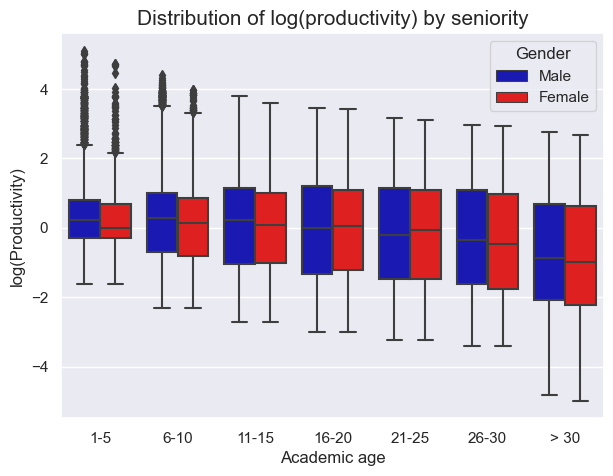

In [163]:
sns.boxplot(data=researchers , x="Seniority_cat", y='log_Productivity', hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Academic age", fontsize=12)
plt.ylabel("log(Productivity)", fontsize=12)
plt.title("Distribution of log(productivity) by seniority", fontsize = 15)
plt.savefig("Figures/logProductivity_Seniority_boxplot", bbox_inches='tight')
plt.show()

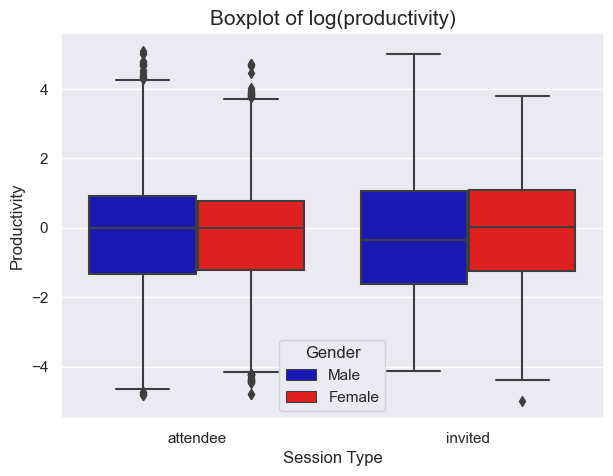

In [164]:
#productivity
sns.boxplot(data=researchers , x="SessionType", y="log_Productivity", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
plt.title("Boxplot of log(productivity)", fontsize = 15)
plt.savefig("Figures/logProductivity_boxplot", bbox_inches='tight')
plt.show()

### Divisions

In [282]:
invDiv_gender = invited[invited.Division == 'FOEP'].groupby(['Year', 'Gender']).count().reset_index()
attDiv_gender = attendees[attendees.Division == 'FOEP'].groupby(['Year', 'Gender']).count().reset_index()

In [283]:
#change over time with FDI
print("Largest:", divGenderRatio_invited['Female invited'].nlargest(n=2))
print("Smallest:", divGenderRatio_invited['Female invited'].nsmallest(n=3))
#FDI, FGSA, DPB, FHPP, FOEP

#FDI: only one, so not worth looking at
#FGSA: too few
#DPB: too few
#FHPP: too few

#find someone else with many females, with more data

Largest: Division
History and Philosophy of Physics    0.500000
Graduate Student Affairs             0.452055
Name: Female invited, dtype: float64
Smallest: Division
Nuclear Physics                       0.000000
Instrument and Measurement Science    0.112903
Laser Science                         0.157895
Name: Female invited, dtype: float64


In [285]:
#show ratio of some specific fields

In [229]:
len(att23[att23.CumulativePaperCount == 0])/len(att23)

0.007829095102263761

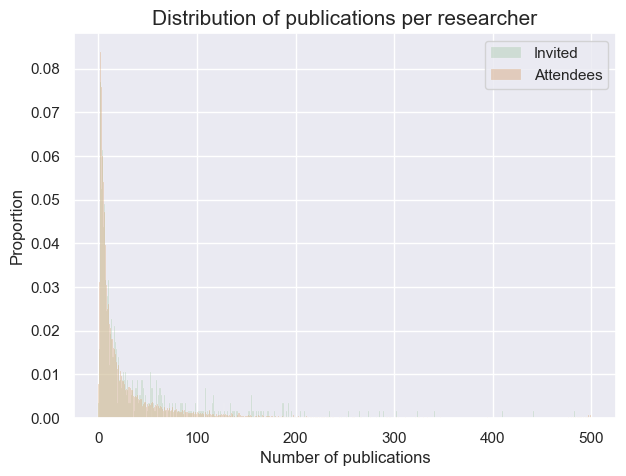

In [238]:
#publication for 2023
inv23 = invited[invited.Year == 2023]
att23 = attendees[attendees.Year == 2023]

sns.histplot(data = inv23 , x = 'CumulativePaperCount', stat = 'proportion', color = 'darkseagreen', label = 'Invited', alpha = 0.3, binwidth = 1)
sns.histplot(data = att23, x = 'CumulativePaperCount', stat = 'proportion', color = 'peru', label = 'Attendees', alpha = 0.3, binwidth = 1)
plt.legend()
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per researcher", fontsize = 15)
plt.show()

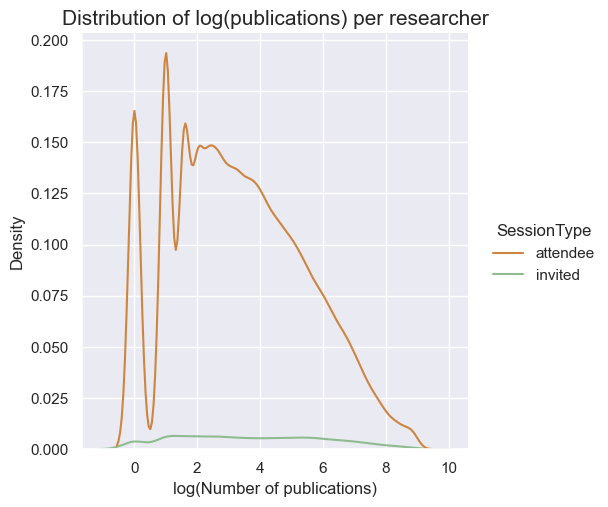

In [215]:
sns.displot(researchers, x = 'log_CumulativePaperCount', kind = 'kde', hue = 'SessionType', palette = ['peru', 'darkseagreen'])
plt.xlabel("log(Number of publications)", fontsize=12)
plt.title("Distribution of log(publications) per researcher", fontsize = 15)
plt.savefig("Figures/logPublications_dist_all.png", bbox_inches='tight')
plt.show()

In [119]:
### distribution(by histogram) of publications for invited speakers(male and female and female indicated) for a few divisions

In [143]:
#FDI: Diversity
#FHPP: Philosopy and history of physics